## Decision Trees Record Data - Python

## Set up data

In [1]:
# Load essential libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

# Read csv file
df = pd.read_csv('../data/cleaned_wf_demo.csv', index_col=0)
print(df.head())

      company  seniority job_category  gender ethnicity       count  \
1  Home Depot          4        Admin  female       api    6.649361   
2  Home Depot          3        empty    male       api    0.114460   
3  Home Depot          5    Scientist    male       api    0.005991   
4  Home Depot          1     Engineer    male       api  192.650237   
5  Home Depot          3     Engineer  female       api   84.062919   

      inflow   outflow        salary  
1   0.027259  0.020727  6.296236e+05  
2   0.000265  0.000297  8.108699e+03  
3   0.001000  0.000000  5.206698e+02  
4  10.110865  6.249455  1.124800e+07  
5   1.707721  1.253758  8.842880e+06  


## Clean data for Decision Trees

In [2]:
# Convert categorical variables to dummy variables using pd.get_dummies

# Dummies for job_category
dummies = pd.get_dummies(df['job_category']).rename(columns=lambda x: 'job_category_' + str(x))
df = pd.concat([df, dummies], axis=1) #add back into the dataframe
df.drop(['job_category'], inplace=True, axis = 1) #remove job_category column

# Repeat for gender
dummies = pd.get_dummies(df['gender']).rename(columns=lambda x: 'gender_' + str(x))
df = pd.concat([df, dummies], axis=1) #add back into the dataframe
df.drop(['gender'], inplace=True, axis = 1) #remove gender column

# Repeat for ethnicity
dummies = pd.get_dummies(df['ethnicity']).rename(columns=lambda x: 'ethnicity_' + str(x))
df = pd.concat([df, dummies], axis=1) #add back into the dataframe
df.drop(['ethnicity'], inplace=True, axis = 1) #remove ethnicity column

# Repeat for company
dummies = pd.get_dummies(df['company']).rename(columns=lambda x: 'company_' + str(x))
df = pd.concat([df, dummies], axis=1) #add back into the dataframe

# Confirm new column names and that there are no NAs
print(df.columns)
print(df.isnull().sum())

Index(['company', 'seniority', 'count', 'inflow', 'outflow', 'salary',
       'job_category_Admin', 'job_category_Engineer', 'job_category_Finance',
       'job_category_Marketing', 'job_category_Operations',
       'job_category_Sales', 'job_category_Scientist', 'job_category_empty',
       'gender_female', 'gender_male', 'ethnicity_api', 'ethnicity_black',
       'ethnicity_hispanic', 'ethnicity_multiple', 'ethnicity_native',
       'ethnicity_white', 'company_Accenture', 'company_Apple',
       'company_Bristol Myers Squibb', 'company_Databricks',
       'company_Goldman Sachs', 'company_Home Depot'],
      dtype='object')
company                         0
seniority                       0
count                           0
inflow                          0
outflow                         0
salary                          0
job_category_Admin              0
job_category_Engineer           0
job_category_Finance            0
job_category_Marketing          0
job_category_Operations   

## Class distribution

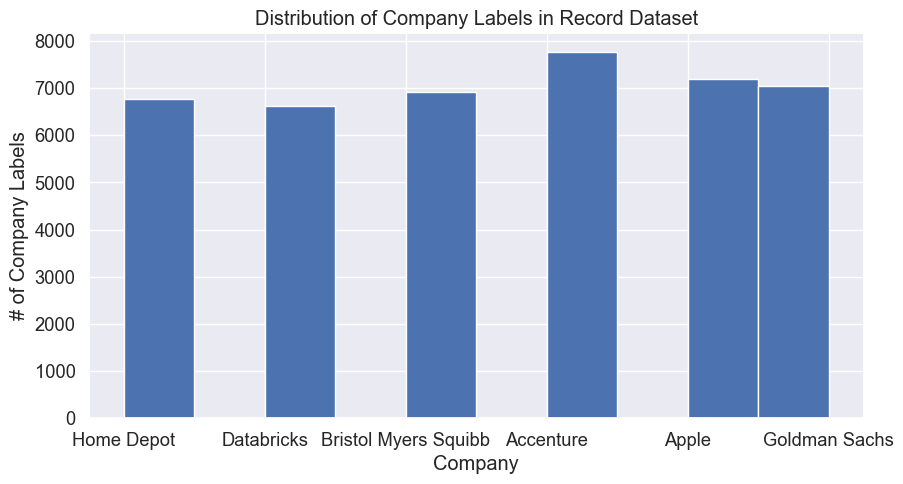

In [3]:
## Examine class distribution
sns.set(font_scale=1.2)

# Visualize class distribution
fig, ax = plt.subplots(figsize=(10,5))
df['company'].hist()
ax.set_title("Distribution of Company Labels in Record Dataset")
ax.set_xlabel("Company")
ax.set_ylabel("# of Company Labels")

# save picture
fig1 = ax.get_figure()
fig1.savefig("../501-project-website/images/DT_record_labels_distribution.png")

## Baseline model

In [4]:
## Baseline model
import random
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def generate_label_data(class_labels, weights,N=10000):
    y=random.choices(class_labels, weights = weights, k = N)
    print("-----GENERATING DATA-----")
    print("unique entries:",Counter(y).keys())  
    print("count of labels:",Counter(y).values()) # counts the elements' frequency
    print("probability of labels:",np.fromiter(Counter(y).values(), dtype=float)/len(y)) # counts the elements' frequency
    return y

## Generate random classifier
def random_classifier(y_data):
    ypred=[];
    max_label=np.max(y_data); #print(max_label)
    for i in range(0,len(y_data)):
        ypred.append(int(np.floor((max_label+1)*np.random.uniform(0,1))))

    print("-----RANDOM CLASSIFIER-----")
    print("count of prediction:",Counter(ypred).values()) # counts the elements' frequency
    print("probability of prediction:",np.fromiter(Counter(ypred).values(), dtype=float)/len(y_data)) # counts the elements' frequency
    print("accuracy",accuracy_score(y_data, ypred))
    print("percision, recall, fscore,",precision_recall_fscore_support(y_data, ypred))

# Random classifier
print("\MULTI-CLASS: UNIFORM LOAD")
y=generate_label_data([0,1,2,3,4],[0.2,0.2,0.2,0.2,0.2],10000)
random_classifier(y)

\MULTI-CLASS: UNIFORM LOAD
-----GENERATING DATA-----
unique entries: dict_keys([3, 2, 0, 4, 1])
count of labels: dict_values([1979, 1985, 2071, 1980, 1985])
probability of labels: [0.1979 0.1985 0.2071 0.198  0.1985]
-----RANDOM CLASSIFIER-----
count of prediction: dict_values([1996, 1972, 2051, 1978, 2003])
probability of prediction: [0.1996 0.1972 0.2051 0.1978 0.2003]
accuracy 0.1975
percision, recall, fscore, (array([0.20677452, 0.19720419, 0.2004008 , 0.18673818, 0.19675456]), array([0.19748914, 0.19899244, 0.20151134, 0.19353209, 0.1959596 ]), array([0.20202519, 0.19809428, 0.20095453, 0.19007444, 0.19635628]), array([2071, 1985, 1985, 1979, 1980]))


## Feature selection

(27, 27)


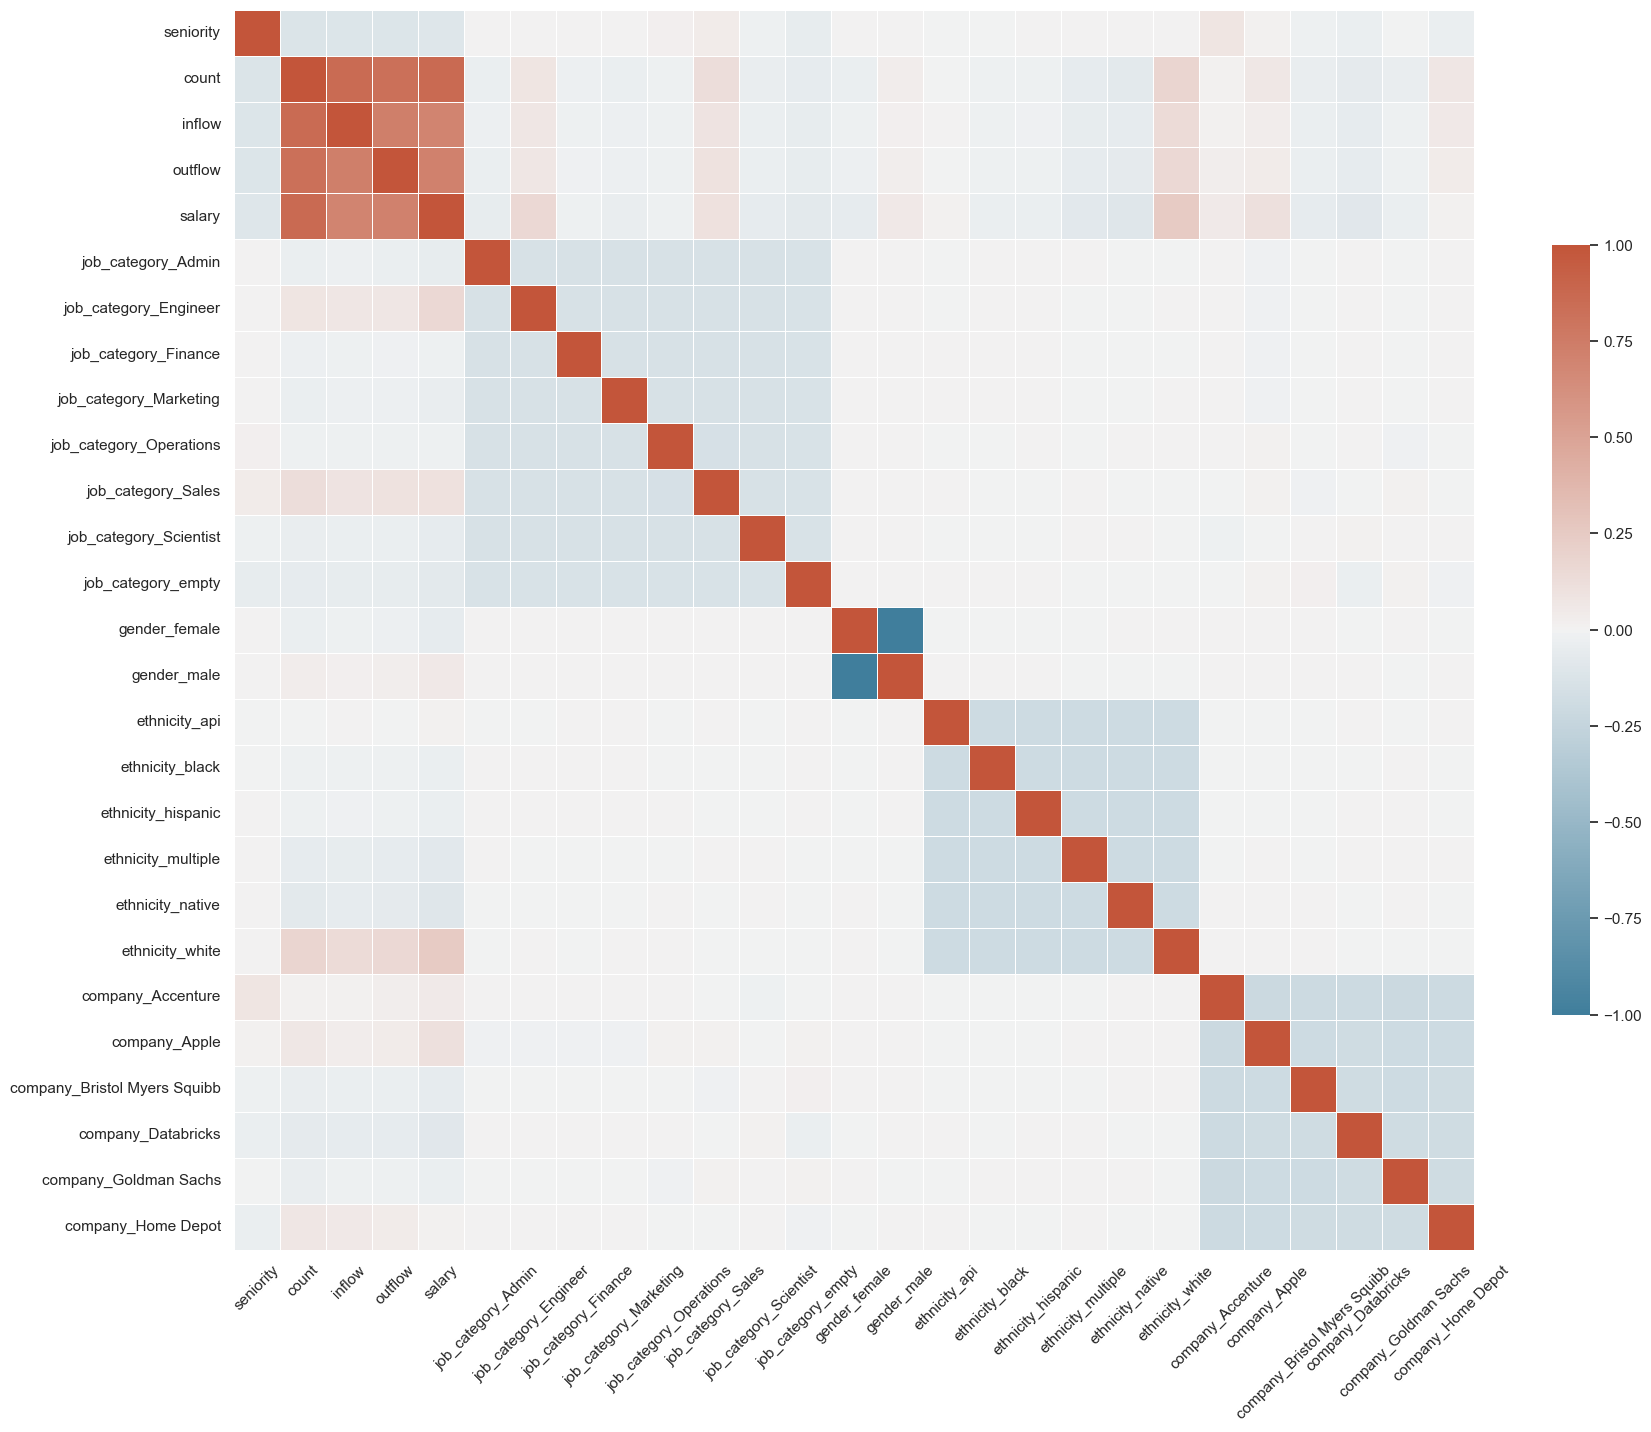

In [5]:
# Identify feature and target columns 
target_cols = [i for i in df.columns if 'company' in i]
feature_cols = df.columns[1:]

# Display heat-map for the correlation matrix
corr = df[feature_cols].corr(); 
print(corr.shape)
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(20, 20))  # Set up the matplotlib figure
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, vmin=-1, vmax=1, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5})
# cbar_kws --> removing the shrink will space them out better

plt.xticks(rotation=45)

plt.show()

## Prepare data for Decision Trees model

In [6]:
## SET X AND Y

# y: convert df['company'] string labels to dummy integers
labels=[]; 
y=[]

for label in df["company"]:
    if label not in labels:
        labels.append(label)
        print("index =",len(labels)-1,": label =",label)
    for i in range(0,len(labels)):
        if(label==labels[i]):
            y.append(i)
y = np.array(y)

# X
X = df.drop(['company', 'company_Accenture', 'company_Apple', 'company_Bristol Myers Squibb', 'company_Goldman Sachs', 'company_Home Depot'], axis = 1)


# Double check
print(X.shape,y.shape)

index = 0 : label = Home Depot
index = 1 : label = Databricks
index = 2 : label = Bristol Myers Squibb
index = 3 : label = Accenture
index = 4 : label = Apple
index = 5 : label = Goldman Sachs
(42336, 22) (42336,)


In [7]:
# Load sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Partion data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=4)

# Check 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(33868, 22)
(33868,)
(8468, 22)
(8468,)


## Support Vector Classifier

In [8]:
# Initialize model

# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Fit model
model = DecisionTreeClassifier(random_state=0)

model

DecisionTreeClassifier(random_state=0)

In [9]:
# Import sklearn
from sklearn.utils.fixes import sklearn

# Fit model to training data
model.fit(X_train, y_train) 

# Predict on X_train
y_train_pred = model.predict(X_train)

## Results

Training set
Accuracy:  99.47443014054565
Number of mislabeled points:  178
Test set
Accuracy:  91.15493623051488
Number of mislabeled points:  749


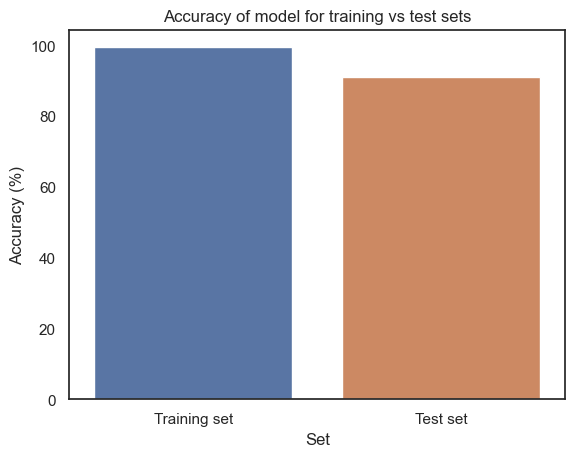

In [10]:
# TEST ACCURACY

# Training set
print("Training set")
print("Accuracy: ", accuracy_score(y_train, y_train_pred) * 100) #accuracy score
print("Number of mislabeled points: ", (y_train != y_train_pred).sum()) #mislabeled points

# Test set
y_test_pred = model.predict(X_test)
print("Test set")
print("Accuracy: ", accuracy_score(y_test, y_test_pred)*100) #accuracy score
print("Number of mislabeled points: ", (y_test != y_test_pred).sum()) #mislabeled points

# Plot
model_accuracies = pd.DataFrame({'Set':['Training set','Test set'], 'Accuracy (%)': [accuracy_score(y_train, y_train_pred) * 100, accuracy_score(y_test, y_test_pred)*100]})
sns.barplot(data=model_accuracies, x="Set", y="Accuracy (%)").set(title = 'Accuracy of model for training vs test sets' )
plt.savefig("../501-project-website/images/DT_record_accuracy.png")

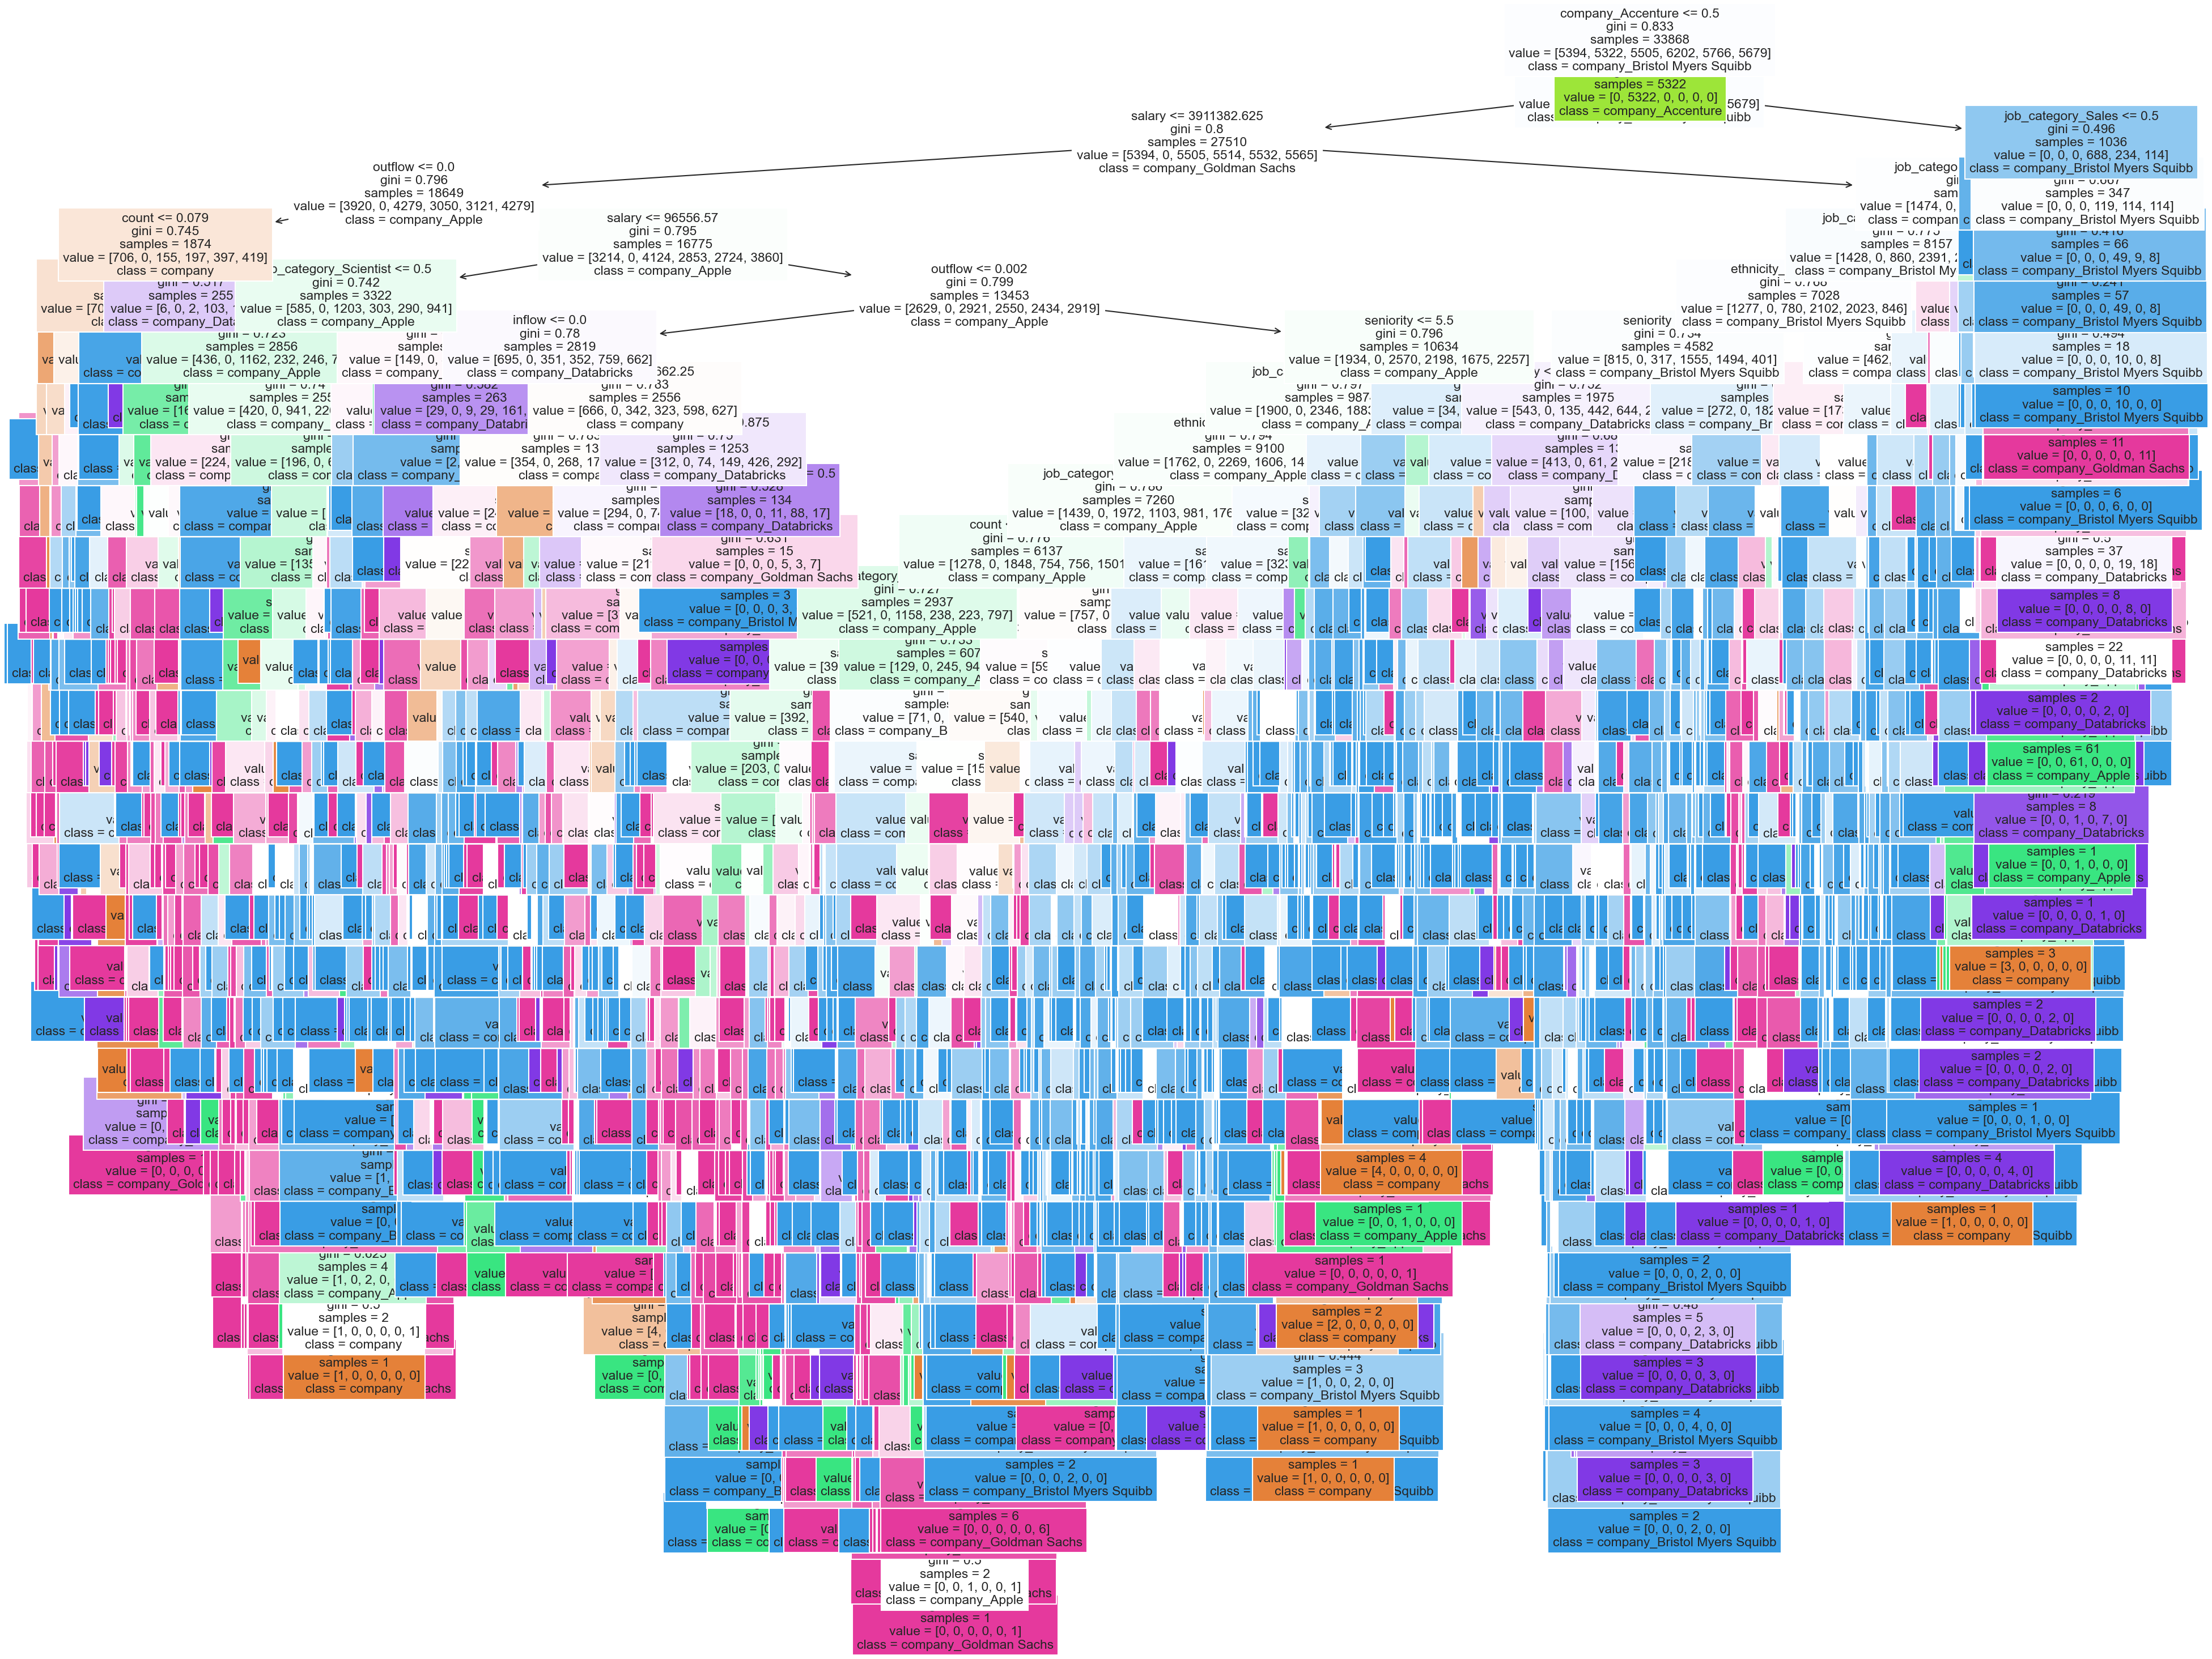

In [11]:
# DECISION TREE

# Import decision tree libraries
from dtreeviz.trees import tree
import graphviz

# Plot decision tree
def plot_tree(model, X, Y):
    fig = plt.figure(figsize=(30, 25), dpi=150)
    _ = tree.plot_tree(model,
                      feature_names = feature_cols,
                       class_names = target_cols,
                       filled = True,
                      fontsize=11)
    fig.savefig('../501-project-website/images/DT_graph.png')
    
plot_tree(model, X, y)

/Users/cynthiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


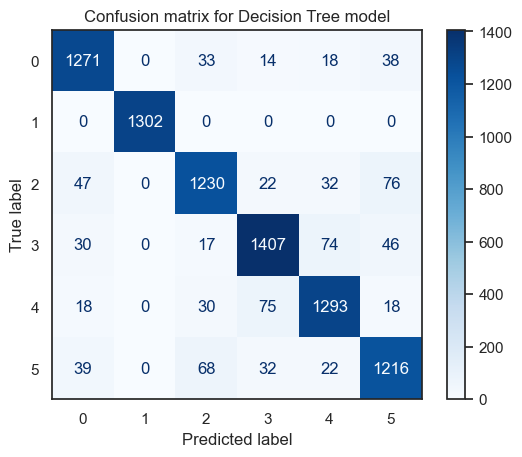

In [12]:
# CONFUSION MATRIX

# Import confusion matrix library
from sklearn.metrics import plot_confusion_matrix

# Create confusion matrix
plot_confusion_matrix(model, X_test , y_test , cmap="Blues")

# Plot confusion matrix
plt.title("Confusion matrix for Decision Tree model")
plt.savefig("../501-project-website/images/DT_record_confusion_matrix.png")